## 환경변수 로딩

In [1]:
from dotenv import load_dotenv
import os

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv(override=True)
PINECONE_API_KEY = os.environ['PINECONE_API_KEY']
# PINECONE_API_KEY
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

## Pinecone 객체생성

In [2]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=PINECONE_API_KEY)

## pinecone DB 인덱스 생성

### wiki index가 있으면 삭제함

In [3]:
index_name = 'wiki'

for idx in pc.list_indexes():
    if idx.name == index_name:
        pc.delete_index(index_name)


### 인덱스 생성

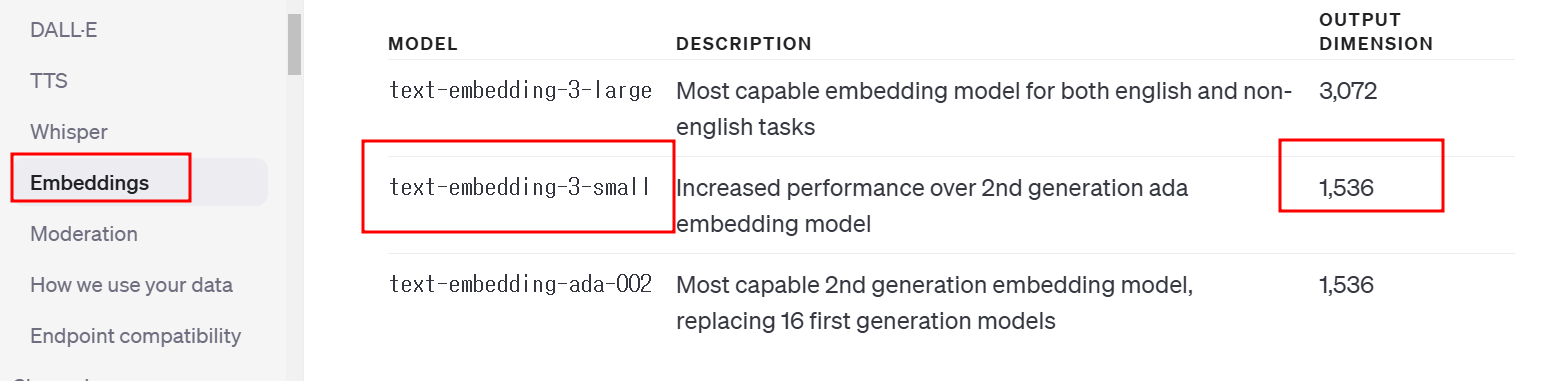

In [4]:
# text-embedding-3-small <- 1536
pc.create_index(
    name=index_name,
    # embedding vetor model이 지원하는 차원값과 동일해야함
    dimension= 1536,
    metric="cosine",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )

)

{
    "name": "wiki",
    "metric": "cosine",
    "host": "wiki-9wtgah8.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "region": "us-east-1",
            "cloud": "aws",
            "read_capacity": {
                "mode": "OnDemand",
                "status": {
                    "state": "Ready",
                    "current_shards": null,
                    "current_replicas": null
                }
            }
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1536,
    "deletion_protection": "disabled",
    "tags": null,
    "_response_info": {
        "raw_headers": {
            "content-type": "application/json",
            "access-control-allow-origin": "*",
            "vary": "access-control-request-headers",
            "access-control-expose-headers": "*",
            "x-pinecone-api-version": "2025-10",
            "x-cloud-trace-context": "38e0eb08

In [5]:
index = pc.Index(index_name)
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '151',
                                    'content-type': 'application/json',
                                    'date': 'Sun, 28 Dec 2025 18:19:17 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '42',
                                    'x-pinecone-request-id': '2728825386238741507',
                                    'x-pinecone-request-latency-ms': '41',
                                    'x-pinecone-response-duration-ms': '43'}},
 'dimension': 1536,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'storageFullness': 0.0,
 'total_vector_count': 0,
 'vector_type': 'dense'}

## langchin_openai 임베딩 객체 생성

In [6]:
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model="text-embedding-3-small", api_key=OPENAI_API_KEY)

## 데이터 준비
- %pip install -qU datasets
-  https://huggingface.co/datasets/legacy-datasets/wikipedia

In [7]:
# 허깅페이디 데이터 다운로드 라이브러리
# %pip install -qU datasets

In [8]:
from datasets import load_dataset

dataset = load_dataset(
    "wikimedia/wikipedia",
    "20231101.simple",   # simple 영어 위키
    split="train[:100]"
)

In [9]:
for record in dataset:
    print(record)
    print("-"*30)


{'id': '1', 'url': 'https://simple.wikipedia.org/wiki/April', 'title': 'April', 'text': 'April (Apr.) is the fourth month of the year in the Julian and Gregorian calendars, and comes between March and May. It is one of the four months to have 30 days.\n\nApril always begins on the same day of the week as July, and additionally, January in leap years. April always ends on the same day of the week as December.\n\nThe Month \n\nApril comes between March and May, making it the fourth month of the year. It also comes first in the year out of the four months that have 30 days, as June, September and November are later in the year.\n\nApril begins on the same day of the week as July every year and on the same day of the week as January in leap years. April ends on the same day of the week as December every year, as each other\'s last days are exactly 35 weeks (245 days) apart.\n\nIn common years, April starts on the same day of the week as October of the previous year, and in leap years, May 

## 문서 split(=chunking)
- chunk 단위로 분할함
- 일반적인 chunk size : 

In [10]:
"""
langchain
 ├─ langchain-core
 ├─ langchain-community
 ├─ langchain-text-splitters   ← ✅ 자동 포함
 └─ (기타 필수 의존성)
"""
""

''

chunk의 크기
- 너무 크면 → 임베딩 품질 저하, 검색 정확도 감소
- 너무 작으면 → 문맥이 잘려 의미 손실
- 300~500 : 교육용, 실습용
- 500~1000 : 현업 실제 서비스

분리 우선순위 (위 → 아래), “가능하면 문단 → 줄 → 단어 → 글자 순서로 잘라라”
- "\n\n" : 문단 단위
- "\n" : 줄 단위
- " " : 단어 단위
- "" : 글자 단위 (최후의 수단)

In [11]:
# split 객체 생성
from langchain_text_splitters import RecursiveCharacterTextSplitter

# RecursiveCharacterTextSplitter:
# 문맥을 최대한 보존하면서 긴 문서를 임베딩용 청크로 나누기 위한 도구
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 400,  # 한 조각(chunk)의 최대 길이
    chunk_overlap = 30,   # 이전 청크와 겹치는 글자 수, 문맥 연결성 유지
    length_function = len,  # 글자 수 기준
    separators=["\n\n", "\n", " ", ""]   # 텍스트를 나눌 때 우선적으로 사용하는 기준
)

## 데이터 업로딩

In [12]:
from tqdm.auto import tqdm

for i, doc in enumerate(tqdm(dataset)):
    full_text = doc["text"]
    # print(full_text)

    chunks = splitter.split_text(full_text)
    print(f"{i} : {chunks}")
    print("-"*30)
    print(len(chunks))


  0%|          | 0/100 [00:00<?, ?it/s]

0 : ['April (Apr.) is the fourth month of the year in the Julian and Gregorian calendars, and comes between March and May. It is one of the four months to have 30 days.\n\nApril always begins on the same day of the week as July, and additionally, January in leap years. April always ends on the same day of the week as December.\n\nThe Month', 'The Month \n\nApril comes between March and May, making it the fourth month of the year. It also comes first in the year out of the four months that have 30 days, as June, September and November are later in the year.', "April begins on the same day of the week as July every year and on the same day of the week as January in leap years. April ends on the same day of the week as December every year, as each other's last days are exactly 35 weeks (245 days) apart.", 'In common years, April starts on the same day of the week as October of the previous year, and in leap years, May of the previous year. In common years, April finishes on the same day o

## 언패킹
```
- *  : 단일 데이터 언팩킹
- ** : 'key: value' 형태로 언팩킹
```

In [13]:
from pprint import pformat
metadata = {
    'wiki_id': str(doc["id"]),  # Wikipedia 문서 ID
    'url': doc["url"],  # Wikipedia 문서 URL
    'title': doc["title"],  # Wikipedia 문서 제목
}

record = {
    'chunk_id': 1,  # 청크 ID
    **metadata,  # 메타데이터 언패킹
    'full_text': full_text,  # 전체 텍스트 <- 메모리에 문제 발생 가능성
}

print(pformat(record))


{'chunk_id': 1,
 'full_text': 'December (Dec.) is the twelfth and last month of the year in '
              'the Gregorian calendar, coming between November (of the current '
              'year) and January (of the following year). It has 31 days. With '
              'the name of the month coming from the Latin decem for "ten", it '
              'was the tenth month of the year before January and February '
              'were added to the Roman calendar.\n'
              '\n'
              'December always begins on the same day of the week as '
              'September, and ends on the same day of the week as April.\n'
              '\n'
              "December's flower is the Narcissus. Its birthstone is the "
              'turquoise.\n'
              '\n'
              'Some of the holidays celebrated in December are Christmas, New '
              "Year's Eve, Kwanzaa, and Hanukkah.\n"
              '\n'
              'The Month \n'
              '\n'
              'December is

## Vector DB에 저장하기
잘게 나누고(chunk) → 임베딩 → Vector DB에 저장
- uuid4() : 각 벡터의 고유 ID 생성
- tqdm : 진행 상황 표시
- time.sleep() : 너무 빠른 요청 방지

In [14]:
# 필요한 라이브러리
from uuid import uuid4
from tqdm.auto import tqdm
import time

In [15]:
# 업로드 설정
BATCH_SIZE = 100  # 100개씩 Vector DB에 저장
texts = []        # chunk 텍스트 모음
metadatas = []    # 메타데이터 모음

In [16]:
# 데이터셋의 각 샘플에 대해 반복합니다. 문서갯수 만큼 반복
for i, doc in enumerate(tqdm(dataset)):

    full_text = doc["text"] # Wikipedia 문서 텍스트
    metadata = {
        'wiki_id': str(doc["id"]),  # Wikipedia 문서 ID
        'title': doc["title"],  # Wikipedia 문서 제목
        'url': doc["url"],      # Wikipedia 문서 URL
    }


    chunks = splitter.split_text(full_text)  # 텍스트를 청크로 분할합니다.
    # print(len(chunks))

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
from tqdm.auto import tqdm
from uuid import uuid4
import time

# 업로드 설정
BATCH_SIZE = 100  # 100개씩 Vector DB에 저장
NAMESPACE = "wiki_ns1"
texts = []        # chunk 텍스트 모음
metadatas = []    # 메타데이터 모음

# 문서 하나씩 처리하기
# dataset : Wikipedia 문서 목록
for doc in tqdm(dataset):
    # full_text : 하나의 위키 문서 전체 내용
    full_text = doc["text"]

    # 문서 정보(메타데이터) 준비
    chunk_metadata = {
        "wiki_id": str(doc["id"]),
        "title": doc["title"],
        "url": doc["url"]
    }

    # 문서를 chunk로 나누기(너무 긴 문서는 LLM이 처리 못함, 작은 조각(chunk)으로 나눔)
    chunks = splitter.split_text(full_text)

    for idx, chunk in enumerate(chunks):
        # texts / metadatas에 임시 저장
        texts.append(chunk)
        metadatas.append({
            "chunk_id": idx,   # chunk_id : 같은 문서 내 몇 번째 조각인지
            # "full_text": chunk[:100], 
            "full_text": chunk, 
            **chunk_metadata
        })
        # 100개 모이면 Vector DB에 저장
        if len(texts) == BATCH_SIZE:
            ids = [str(uuid4()) for _ in range(BATCH_SIZE)]
        
            # 임베딩 -> Pinecone 업로드
            embeddings = embedding.embed_documents(texts)

            index.upsert(
                vectors=zip(ids, embeddings, metadatas),
                namespace=NAMESPACE
            )
            # 초기화 후 다음 배치로 
            texts = []
            metadatas = []
            time.sleep(1)

# 마지막 남은 chunk 업로드 누락
if texts:
    ids = [str(uuid4()) for _ in range(len(texts))]
    embeddings = embedding.embed_documents(texts)
    index.upsert(
        vectors=zip(ids, embeddings, metadatas),
        namespace=NAMESPACE
    )

  0%|          | 0/100 [00:00<?, ?it/s]